In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn import metrics, ensemble, svm, impute, preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
SEED = 42

In [3]:
data = pd.read_csv('ae_retro_data_continuous.csv', na_values=['?'])
data_discrete = pd.read_csv('ae_retro_data_discrete.csv', na_values=['?'])
y_col = 'CORR_CATEGORY'
y_classes = ['ADMIT', 'LONG', 'SHORT']
drop_cols = ['DECISION_OFFSET', y_col]

mask = data.DECISION_OFFSET == 60
data = data[mask]
#X[X.TEMP_TYPE == 'AXILLARY'].TEMP += 0.8
data_discrete = data_discrete[mask]
y = data[y_col]
X = data.drop(columns=drop_cols)
X_discrete = data_discrete.drop(columns=drop_cols)
X

,NUM_REG_AGE,PRIM_CARE,CHEST_CLINIC,CURR_INH_STEROID,NUM_AGE_FIRST_SX,PREV_ORAL_STEROID,PREV_ED_LAST_YEAR,PREV_ADM,ENV_SMOKE,ENV_DANDER,...,NUM_REASS_HEART_RATE,NUM_REASS_SAO2,REASS_SAO2_ENV,REASS_AIR_ENTRY,REASS_DISTRESS,REASS_COLOUR,REASS_EXP_WHEEZE,REASS_INSP_WHEEZE,REASS_RETRACTIONS,NUM_MASKS
0,3.301370,FD,NO,NaN,2.0,GE_1M_LT_3M,2_VISITS,FLOOR,NaN,NaN,...,84.0,NaN,NaN,NaN,NONE,PINK,PRESENT,PRESENT,NaN,0
1,5.205479,FD,NO,PRN,3.0,GE_12M,NONE,NONE,NaN,NaN,...,NaN,99.0,SUPPL_O2,GOOD,NaN,NaN,ABSENT,ABSENT,ABSENT,1
4,4.739726,FD,YES,PRN,2.0,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,NaN,NaN,NaN,GOOD,NaN,NaN,ABSENT,ABSENT,PRESENT,1
5,4.312329,FD,YES,PRN,2.0,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,158.0,93.0,ROOM_AIR,GOOD,NaN,PALE,PRESENT,PRESENT,PRESENT,3
7,8.758904,FD,NO,NONE,6.0,GE_3M_LT_12M,2_VISITS,NONE,NaN,NaN,...,NaN,NaN,NaN,REDUCED,NONE,NaN,PRESENT,NaN,PRESENT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,2.126027,FD,NO,NONE,1.5,NONE,NONE,NONE,NaN,NaN,...,150.0,NaN,NaN,REDUCED,NaN,NaN,NaN,NaN,NaN,1
1056,3.052055,FD,NO,NaN,2.0,GE_3M_LT_12M,2_VISITS,FLOOR,NaN,NaN,...,123.0,93.0,ROOM_AIR,REDUCED,NaN,PINK,PRESENT,PRESENT,PRESENT,1
1059,1.786301,FD,NO,PRN,1.0,GE_12M,1_VISIT,FLOOR,NaN,NaN,...,134.0,95.0,ROOM_AIR,GOOD,NaN,NaN,PRESENT,PRESENT,PRESENT,1
1061,2.008219,FD,NO,PRN,2.0,GE_12M,1_VISIT,NONE,NaN,NaN,...,168.0,91.0,ROOM_AIR,GOOD,NaN,PALE,PRESENT,PRESENT,PRESENT,2


In [4]:
nans = pd.DataFrame(X.isna().sum(), columns=['nan count']).sort_values(by='nan count', ascending=False)
nans['nan %'] = np.round(nans['nan count'] / 427 * 100, 1)
nans

,nan count,nan %
NUM_REASS_TEMP,385,90.2
REASS_DISTRESS,375,87.8
ENV_CARPETS,364,85.2
ENV_DANDER,306,71.7
ALLG_EXP,306,71.7
TRIAGE_INSP_WHEEZE,303,71.0
ENV_SMOKE,300,70.3
TRIAGE_EXP_WHEEZE,274,64.2
TRIAGE_RETRACTIONS,269,63.0
TRIAGE_DISTRESS,258,60.4


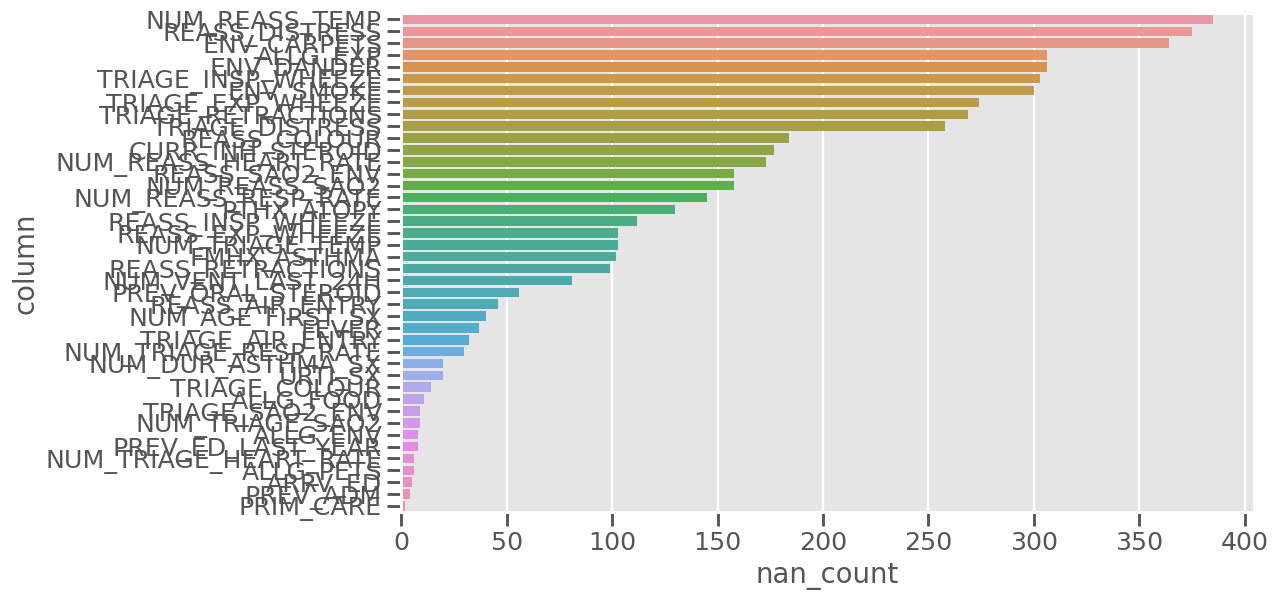

In [18]:
def plot_missing_values(df, *, ax=None):
    na = pd.DataFrame(df.isna().sum().reset_index())
    na.columns = ['column', 'nan_count']
    na = na[na.nan_count > 0]
    na = na.sort_values(by='nan_count', ascending=False)
    sns.barplot(y='column', x='nan_count', data=na, ax=ax)
    
plot_missing_values(X)

<AxesSubplot:xlabel='CORR_CATEGORY', ylabel='count'>

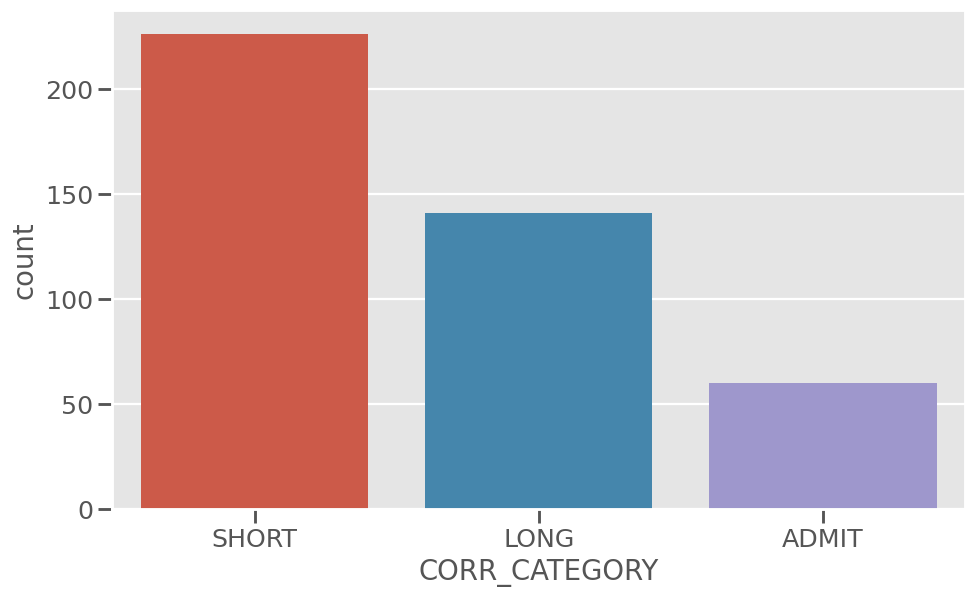

In [19]:
plt.rc('figure', figsize=(10, 6))
sns.countplot(x=y_col, data=data, order=y_classes[::-1])

In [5]:
def auc(y, Y):
    Y = (Y.T / Y.sum(1)).T
    return metrics.roc_auc_score(y, Y, average='macro', multi_class='ovr', labels=y_classes)

def roc_curves(y, Y):
    return {y_class: metrics.roc_curve(y == y_class, Y[:,i]) for i, y_class in enumerate(y_classes)}

def run_experiment(X_, y_, *, n_splits=10, n_repeats=5, dataset, classifier='catboost', class_weights='Balanced', handle_nan=False):
    cat_features = [col for col in X_.columns if not col.startswith('NUM_')]
    cat_features_idx = [i for i, col in enumerate(X_.columns) if not col.startswith('NUM_')]
    X_[cat_features] = X_[cat_features].fillna(value='?')
    if not classifier.startswith('catboost'):
        X_ = pd.get_dummies(X_, drop_first=True)
    X_, y_ = X_.to_numpy(), y_.to_numpy()
    
    print(classifier, dataset)
    results = []
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    for i, (idx_tr, idx_te) in enumerate(kfold.split(X_, y_)):
        X_tr, X_te = X_[idx_tr], X_[idx_te]
        y_tr, y_te = y_[idx_tr], y_[idx_te]
        
        if handle_nan:
            imputer = impute.KNNImputer(missing_values=np.nan)
            X_tr = imputer.fit_transform(X_tr)
            X_te = imputer.transform(X_te)
        
        if classifier.startswith('catboost'):
            M = CatBoostClassifier(silent=True, n_estimators=1000, loss_function='MultiClassOneVsAll', auto_class_weights=class_weights, class_names=y_classes, cat_features=cat_features_idx)
        elif classifier == 'svc':
            M = svm.SVC(probability=True, C=100, class_weight='balanced', random_state=1337)
        else:
            assert False
            
        M.fit(X_tr, y_tr)
        assert list(M.classes_) == y_classes
        Y_te = M.predict_proba(X_te)
        res = dict(dataset=dataset, classifier=classifier, label=dataset+' - '+classifier, iter=i // n_splits, auc=auc(y_te, Y_te), roc=roc_curves(y_te, Y_te))
        results.append(res)
        print(i+1, '/', n_splits*n_repeats, res['auc'])
            
    return results
        
results = []
results += run_experiment(X, y, dataset='continuous', classifier='svc', handle_nan=True)
results += run_experiment(X_discrete, y, dataset='discrete', classifier='svc', handle_nan=True)
results += run_experiment(X, y, dataset='continuous', class_weights=None)
results += run_experiment(X_discrete, y, dataset='discrete', class_weights=None)
results += run_experiment(X, y, dataset='continuous', classifier='catboost weighted')
results += run_experiment(X_discrete, y, dataset='discrete', classifier='catboost weighted')
df = pd.DataFrame(results)
df.to_pickle('results.pkl')
df

svc continuous
1 / 50 0.6633497133497134
2 / 50 0.6701748224986606
3 / 50 0.7688177468537288
4 / 50 0.6458898928913922
5 / 50 0.747077683809318
6 / 50 0.6038044041042543
7 / 50 0.8191494986097685
8 / 50 0.7212934331981952
9 / 50 0.7043788222359652
10 / 50 0.651710414805653
11 / 50 0.7489021489021489
12 / 50 0.6778456653269247
13 / 50 0.7273358494497923
14 / 50 0.6025384347723178
15 / 50 0.6841910126018073
16 / 50 0.6624465437808765
17 / 50 0.7082316628043764
18 / 50 0.6999370118417737
19 / 50 0.6485358116310498
20 / 50 0.6518421173183078
21 / 50 0.7727604227604227
22 / 50 0.7319768365495501
23 / 50 0.5825973113829185
24 / 50 0.6431221969452854
25 / 50 0.79140925032979
26 / 50 0.654556859279498
27 / 50 0.7078382944949663
28 / 50 0.7222451270070317
29 / 50 0.5522566939233605
30 / 50 0.69402643212167
31 / 50 0.6785850785850785
32 / 50 0.6919099330643559
33 / 50 0.7352642533302203
34 / 50 0.6436471918480914
35 / 50 0.722189162818848
36 / 50 0.6584472242643157
37 / 50 0.6889246174853371
38 

,dataset,classifier,label,iter,auc,roc
0,continuous,svc,continuous - svc,0,0.663350,"{'ADMIT': ([0.0, 0.02702702702702703, 0.027027..."
1,continuous,svc,continuous - svc,0,0.670175,"{'ADMIT': ([0.0, 0.0, 0.02702702702702703, 0.0..."
2,continuous,svc,continuous - svc,0,0.768818,"{'ADMIT': ([0.0, 0.0, 0.0, 0.02702702702702703..."
3,continuous,svc,continuous - svc,0,0.645890,"{'ADMIT': ([0.0, 0.0, 0.10810810810810811, 0.1..."
4,continuous,svc,continuous - svc,0,0.747078,"{'ADMIT': ([0.0, 0.0, 0.0, 0.02702702702702703..."
...,...,...,...,...,...,...
295,discrete,catboost weighted,discrete - catboost weighted,4,0.812771,"{'ADMIT': ([0.0, 0.0, 0.0, 0.05405405405405406..."
296,discrete,catboost weighted,discrete - catboost weighted,4,0.679331,"{'ADMIT': ([0.0, 0.0, 0.05405405405405406, 0.0..."
297,discrete,catboost weighted,discrete - catboost weighted,4,0.704265,"{'ADMIT': ([0.0, 0.0, 0.0, 0.2777777777777778,..."
298,discrete,catboost weighted,discrete - catboost weighted,4,0.670988,"{'ADMIT': ([0.0, 0.0, 0.1111111111111111, 0.11..."


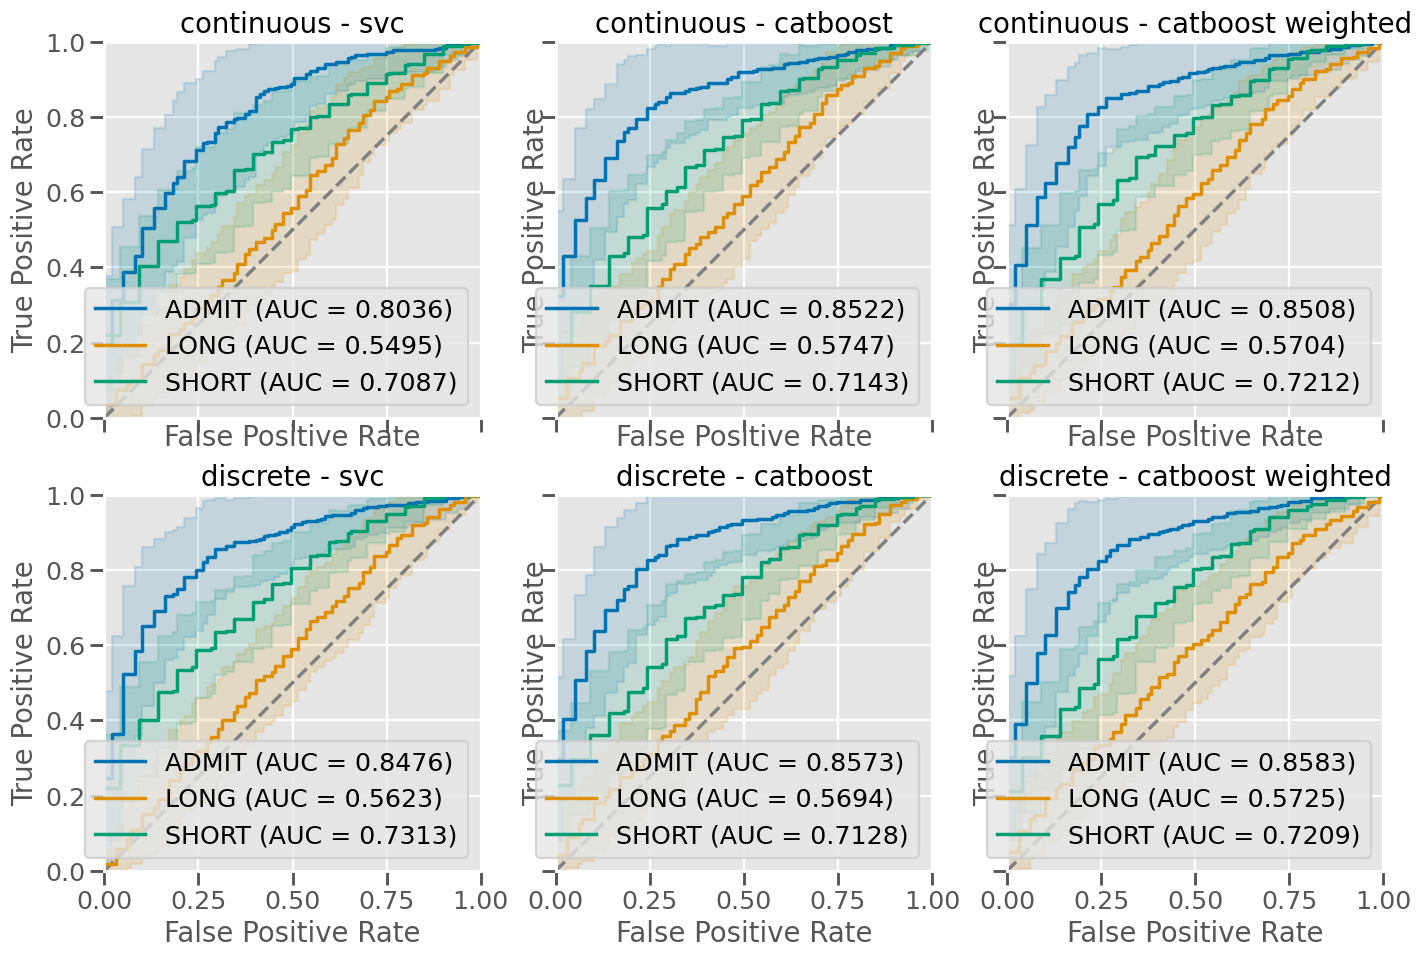

In [20]:
def plot_roc_multiclass(rocs, *, ax=None, title=None, y_classes=y_classes):
    if ax is None: fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], ls='--', color='grey')
    ax.set_aspect('equal'); ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    colors = sns.color_palette('colorblind', n_colors=len(y_classes))
    for color, y_class in zip(colors, y_classes):
        xs = np.linspace(0, 1, 100)
        interp_tpr = np.array([np.interp(xs, x[y_class][0], x[y_class][1]) for x in rocs])
        mean, std = interp_tpr.mean(0), interp_tpr.std(0)
        ax.step(xs, mean, color=color, label=f'{y_class} (AUC = {metrics.auc(xs, mean):.4f})')
        ax.fill_between(xs, mean - std, mean + std, alpha=0.15, color=color, step='pre')
    ax.set_title(title)
    ax.legend(loc='lower right')
    
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(15, 10))
axs = axs.reshape(-1)
i = 0
for dataset in ['continuous', 'discrete']:
    for classifier in ['svc', 'catboost', 'catboost weighted']:
        plot_roc_multiclass(df[(df.dataset == dataset) & (df.classifier == classifier)].roc, ax=axs[i], title=dataset+' - '+classifier)
        i += 1
plt.show()

In [7]:
df = pd.read_pickle('results.pkl')

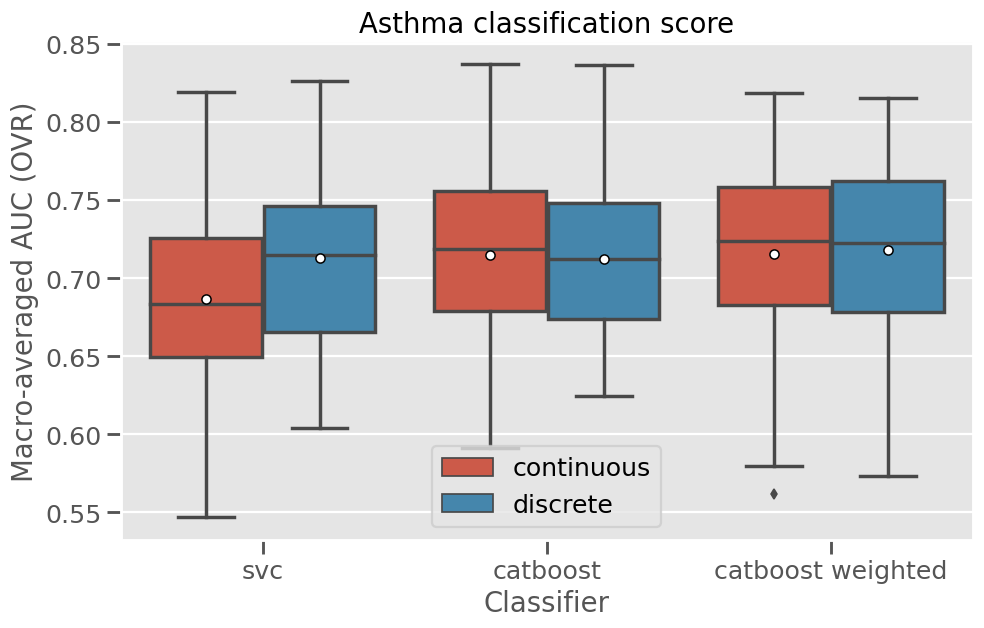

In [23]:
sns.boxplot(x='classifier', y='auc', hue='dataset', data=df, showmeans=True, meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='k'))
plt.xlabel('Classifier')
plt.ylabel('Macro-averaged AUC (OVR)')
plt.title('Asthma classification score')
plt.legend(loc='lower center')
plt.show()

In [35]:
df[['dataset', 'classifier', 'auc']].groupby(['classifier', 'dataset']).mean()

auc
classifier        dataset             
catboost          continuous  0.714998
                  discrete    0.712645
catboost weighted continuous  0.715622
                  discrete    0.718049
svc               continuous  0.686898
                  discrete    0.713311